# Init

In [1]:
import pandas as pd
import os

# Data

In [2]:
DATA_DIR='../data'
normal_sim_path = os.path.join(DATA_DIR, 'sim_normal_offset.csv')
data_df = pd.read_csv(normal_sim_path, sep=';', index_col='date_times')

In [3]:
data_df.head()

,feature1,feature2,target,feature2_breaked,target_shifted_feature2
date_times,,,,,
2020-01-01,1.331587,0.715279,2.762144,0.715279,2.762144
2020-01-02,-1.545400,-0.008384,-1.562168,-0.008384,-1.562168
2020-01-03,0.621336,-0.720086,-0.818835,-0.720086,-0.818835
2020-01-04,0.265512,0.108549,0.482609,0.108549,0.482609
2020-01-05,0.004291,-0.174600,-0.344909,-0.174600,-0.344909


# Model: with real break point

In [4]:
track_col = 'feature2_breaked'
n_timepoints = data_df.shape[0]
n_timepoints

365

In [5]:
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [6]:
mod = pm.Model()

In [7]:
with mod:
    T = pm.Uniform('changepoint', 0, n_timepoints)    
    mu = pm.HalfNormal('mu', sd=4, shape=2)
    grp = (range(0, n_timepoints) > T) * 1
    y_obs = pm.Normal('y_obs', mu=mu[grp], observed = data_df[track_col].values)

In [8]:
with mod:
    step =  pm.Slice()
    trace = pm.sample(step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [mu]
>Slice: [changepoint]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1217.70draws/s]


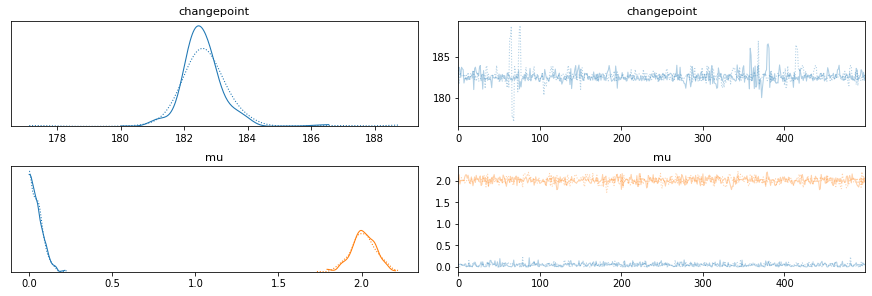

In [9]:
pm.traceplot(trace);

# Model: with no real break point

In [10]:
track_col = 'feature1'
n_timepoints = data_df.shape[0]
n_timepoints

365

In [11]:
mod = pm.Model()
with mod:
    T = pm.Uniform('changepoint', 0, n_timepoints)    
    mu = pm.HalfNormal('mu', sd=4, shape=2)
    grp = (range(0, n_timepoints) > T) * 1
    y_obs = pm.Normal('y_obs', mu=mu[grp], observed = data_df[track_col].values)

In [12]:
with mod:
    step =  pm.Slice()
    trace = pm.sample(step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [mu]
>Slice: [changepoint]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1147.96draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


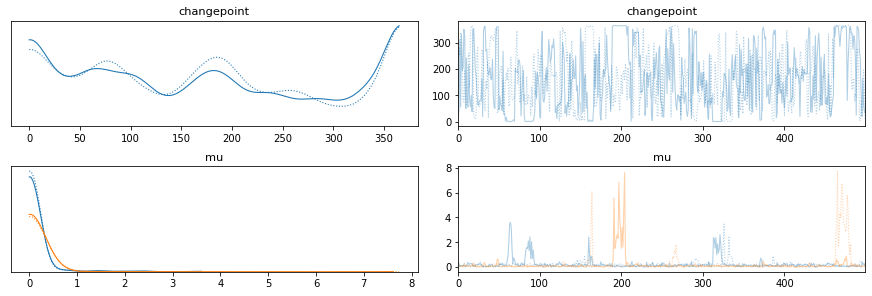

In [13]:
pm.traceplot(trace);

In [15]:
trace.__dict__

{'_straces': {0: <pymc3.backends.ndarray.NDArray at 0x11d5192e8>,
  1: <pymc3.backends.ndarray.NDArray at 0x11d46c358>},
 '_report': <pymc3.backends.report.SamplerReport at 0x11d1ab400>}

## Normal test for change point

In [17]:
from scipy import stats

In [21]:
stats.normaltest(trace['changepoint'])

NormaltestResult(statistic=511.52213459232087, pvalue=8.401944096853077e-112)

In [29]:
import matplotlib.pyplot as plt
import numpy as np

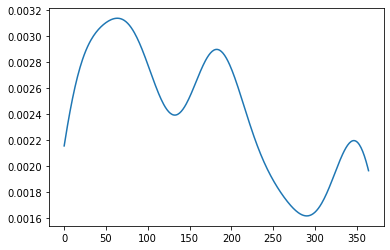

In [26]:
changepoints_range = range(0,365)
kde_changepoints = stats.gaussian_kde(trace['changepoint'])(changepoints_range)
plt.plot(changepoints_range, kde_changepoints)

AttributeError: 'Rectangle' object has no property 'kde'

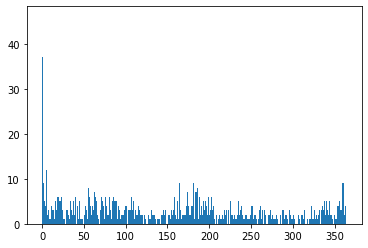

In [34]:
plt.hist(trace['changepoint'].astype(np.int), bins=365, kde=True)

# Refs
* https://cscherrer.github.io/post/bayesian-changepoint/